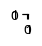

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

In [19]:
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
%ls ../output/250219_FrancisCovid_IndividualAnalyses/

TBCRalign/                       VAE_TS_NoTRP/
VAE_OS_CsTRP/                    iedb_sarscov2_anyAlphaBeta.xlsx
VAE_OS_NoTrp/                    iedb_sarscov2_fullpaired.xlsx
VAE_TS_CsTRP/                    tcrdist3/


In [3]:
train_ts = pd.read_csv('../data/filtered/240618_nettcr_exp_nested_swap_train_p0234.csv').query('partition!=0')
train_os = pd.read_csv('../data/filtered/240618_nettcr_exp_nested_posonly_train_p0234.csv').query('partition!=0')

In [63]:
glob.glob('../output/250219_FrancisCovid_IndividualAnalyses/*/')

['../output/250219_FrancisCovid_IndividualAnalyses/TBCRalign/',
 '../output/250219_FrancisCovid_IndividualAnalyses/tcrdist3/',
 '../output/250219_FrancisCovid_IndividualAnalyses/VAE_OS_NoTrp/',
 '../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_CsTRP/',
 '../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_NoTRP/',
 '../output/250219_FrancisCovid_IndividualAnalyses/VAE_OS_CsTRP/']

In [4]:
lvl0 = pd.read_csv('../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_CsTRP/concat_siglvl_ns.csv')
lvl1 = pd.read_csv('../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_CsTRP/concat_siglvl_1.csv')
lvl2 = pd.read_csv('../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_CsTRP/concat_siglvl_2.csv')
lvl3 = pd.read_csv('../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_CsTRP/concat_siglvl_3.csv')
lvl4 = pd.read_csv('../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_CsTRP/concat_siglvl_4.csv')
lvlcols=['tcr','v_beta','d_beta','j_beta','v_alpha','j_alpha', 'A1','A2','A3', 'B1','B2','B3', 'Subject','count','Run','cluster_count', 'cluster_percent', 'cluster_binom_pval','merged_index']

In [5]:
top1p = pd.read_csv('../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_CsTRP/concat_top1_percent.csv')
bot1p = pd.read_csv('../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_CsTRP/concat_bot1_percent.csv')
top50 = pd.read_csv('../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_CsTRP/concat_top50.csv')
bot50 = pd.read_csv('../output/250219_FrancisCovid_IndividualAnalyses/VAE_TS_CsTRP/concat_bot50.csv')

In [6]:
from src.utils import flatten_level_columns
def read_iedb(fn):
    df=flatten_level_columns(pd.read_excel(fn, header=[0,1]))
    df.columns = df.columns.str.replace(' ','-')
    return df 
cov2 = ['SARS-CoV2', 'Severe acute respiratory syndrome coronavirus 2 Wuhan/Hu-1/2019']

In [7]:
covid_any = read_iedb('../output/250219_FrancisCovid_IndividualAnalyses/iedb_sarscov2_anyAlphaBeta.xlsx').query('`epitope_source-organism` in @cov2')
covid_pair = read_iedb('../output/250219_FrancisCovid_IndividualAnalyses/iedb_sarscov2_fullpaired.xlsx').query('`epitope_source-organism` in @cov2')
cols_to_drop = covid_any.columns[covid_any.isna().all(axis=0)]
covid_any.drop(columns = cols_to_drop, inplace=True)
covid_pair.drop(columns = cols_to_drop, inplace=True)
covid_any['db_index'] = [f'db_idx_{i:05}' for i in range(len(covid_any))]
covid_pair['db_index'] = [f'db_idx_{i:05}' for i in range(len(covid_pair))]

In [8]:
covid_any['db_index'] = [f'db_any_{i:05}' for i in range(len(covid_any))]
covid_pair['db_index'] = [f'db_pair_{i:05}' for i in range(len(covid_pair))]
covid_any.head(3)

,receptor_group-iri,receptor_iedb-receptor-id,receptor_reference-name,receptor_type,reference_iedb-iri,epitope_iedb-iri,epitope_name,epitope_source-molecule,epitope_source-organism,assay_type,...,chain-2_cdr3-calculated,chain-2_cdr3-start-calculated,chain-2_cdr3-end-calculated,chain-2_cdr1-calculated,chain-2_cdr1-start-calculated,chain-2_cdr1-end-calculated,chain-2_cdr2-calculated,chain-2_cdr2-start-calculated,chain-2_cdr2-end-calculated,db_index
3,http://www.iedb.org/receptor/8670,9437,NaN,alphabeta,http://www.iedb.org/reference/1036945,http://www.iedb.org/epitope/1074888,FLPFFSNVTWFHAI,Spike glycoprotein,SARS-CoV2,T cell,...,ASSIRSSYEQY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,db_any_00000
4,http://www.iedb.org/receptor/8670,9437,NaN,alphabeta,http://www.iedb.org/reference/1036945,http://www.iedb.org/epitope/1075108,VQPTESIVRFPNITNLCPF,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,T cell,...,ASSIRSSYEQY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,db_any_00001
6,http://www.iedb.org/receptor/8678,9445,NaN,alphabeta,http://www.iedb.org/reference/1036945,http://www.iedb.org/epitope/1074888,FLPFFSNVTWFHAI,Spike glycoprotein,SARS-CoV2,T cell,...,ASSIGVYGYT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,db_any_00002


In [9]:
c1cols = [x for x in covid_any.columns if ('cdr1' in x) and ("start" not in x and 'end' not in x)]
c2cols = [x for x in covid_any.columns if ('cdr2' in x) and ("start" not in x and 'end' not in x)]
c12cols = c1cols+c2cols
c3cols = [x for x in covid_any.columns if 'cdr3' in x and "start" not in x and 'end' not in x]
seqcols = [x for x in c1cols+c2cols+c3cols if "start" not in x and 'end' not in x]
genecols = [x for x in covid_any.columns if 'gene' in x]
assaycols = [x for x in covid_any.columns if 'assay' in x]
epicols = [x for x in covid_any.columns if 'epitope' in x]

keepcols = ['assay_mhc-allele-names']+seqcols+genecols+epicols+genecols
keep3cols = ['assay_mhc-allele-names']+c3cols+genecols+epicols+genecols
covid_any.loc[(~covid_any[c12cols].isna()).any(axis=1)][c12cols]

,chain-1_cdr1-calculated,chain-2_cdr1-calculated,chain-1_cdr2-calculated,chain-2_cdr2-calculated
97903,NSASQS,LNHDA,VYSSG,SQIVND
97904,DRGSQS,SEHNR,IYSNGD,FQNEAQ
97905,YSGSPE,SGHAT,HISR,FQNNGV
97906,NSASQS,SEHNR,VYSSG,FQNEAQ
97907,TSESDYY,SGHNS,QEAYKQQN,FNNNVP
97908,TSESDYY,SGHNS,QEAYKQQN,FNNNVP


In [10]:
# it's the same 6 datapoints that has the full CDR1-2-3_A/B
covid_pair.loc[(~covid_pair[c12cols].isna()).any(axis=1)][c12cols]

,chain-1_cdr1-calculated,chain-2_cdr1-calculated,chain-1_cdr2-calculated,chain-2_cdr2-calculated
3377,NSASQS,LNHDA,VYSSG,SQIVND
3378,DRGSQS,SEHNR,IYSNGD,FQNEAQ
3379,YSGSPE,SGHAT,HISR,FQNNGV
3380,NSASQS,SEHNR,VYSSG,FQNEAQ
3381,TSESDYY,SGHNS,QEAYKQQN,FNNNVP
3382,TSESDYY,SGHNS,QEAYKQQN,FNNNVP


In [26]:
# Find only the sequences cause the gene formatting is iffy
def find_cdr3(row, db, case="or"):
    chain_dict = {'A3': ('`chain-1_cdr3-calculated`', '`chain-1_cdr3-curated`'), 
                  'B3': ('`chain-2_cdr3-calculated`', '`chain-2_cdr3-curated`')}
    ac1, ac2 = '`chain-1_cdr3-calculated`', '`chain-1_cdr3-curated`'
    bc1, bc2 = '`chain-2_cdr3-calculated`', '`chain-2_cdr3-curated`'
    A3 = row['A3']
    B3 = row['B3']
    match = db.query(f'({ac1}.str.contains(@A3) or {ac2}.str.contains(@A3)) {case} ({bc1}.str.contains(@B3) or {bc2}.str.contains(@B3))')
    if len(match)==0:
        return 'none'
    else:
        return match['db_index'].unique()

def find_train(row, db, case="or"):
    a3=row['A3']
    b3=row['B3']
    match = db.query(f'A3==@a3 {case} B3==@b3')
    if len(match)==0:
        return 'none'
    else:
        return match['raw_index'].unique()

In [38]:
top50['match_train'] = top50.apply(find_train, db=train_ts, case="and", axis=1)
bot50['match_train'] = bot50.apply(find_train, db=train_ts, case="and", axis=1)
top50['match_any_id'] = top50.apply(find_cdr3, db=covid_any, case="or", axis=1)
bot50['match_any_id'] = bot50.apply(find_cdr3, db=covid_any, case="or", axis=1)

In [32]:
lvl0['match_any_id'] = lvl0.apply(find_cdr3, db=covid_any, case="or", axis=1)
lvl1['match_any_id'] = lvl1.apply(find_cdr3, db=covid_any, case="or", axis=1)
lvl2['match_any_id'] = lvl2.apply(find_cdr3, db=covid_any, case="or", axis=1)
lvl3['match_any_id'] = lvl3.apply(find_cdr3, db=covid_any, case="or", axis=1)
lvl4['match_any_id'] = lvl4.apply(find_cdr3, db=covid_any, case="or", axis=1)
top1p['match_any_id'] = top1p.apply(find_cdr3, db=covid_any, case="or", axis=1)
bot1p['match_any_id'] = bot1p.apply(find_cdr3, db=covid_any, case="or", axis=1)
top50['match_any_id'] = top50.apply(find_cdr3, db=covid_any, case="or", axis=1)
bot50['match_any_id'] = bot50.apply(find_cdr3, db=covid_any, case="or", axis=1)
# lvl0['match_pair_id'] = lvl0.apply(find_cdr3, db=covid_pair, case="and", axis=1)
# lvl1['match_pair_id'] = lvl1.apply(find_cdr3, db=covid_pair, case="and", axis=1)
# lvl2['match_pair_id'] = lvl2.apply(find_cdr3, db=covid_pair, case="and", axis=1)
# lvl3['match_pair_id'] = lvl3.apply(find_cdr3, db=covid_pair, case="and", axis=1)
# lvl4['match_pair_id'] = lvl4.apply(find_cdr3, db=covid_pair, case="and", axis=1)

In [ ]:
# select top X and bottom X% instead of significance level --> redo this match query thing
# and do the same with training set and hope not to see the proportions increase

In [55]:
print('Found in IEDB (A3 OR B3 match)')
print(f"bot 1%:\t", round((len(bot1p.query('match_any_id!="none"'))/ len(bot1p)),4))
print(f"top 1%:\t", round((len(top1p.query('match_any_id!="none"'))/ len(top1p)),4))
print(f"bot 50:\t", round((len(bot50.query('match_any_id!="none"'))/ len(bot50)),4))
print(f"top 50:\t", round((len(top50.query('match_any_id!="none"'))/ len(top50)),4))
print('*'*30)
print(f'lvl 0:\t', round((len(lvl0.query('match_any_id!="none"'))/ len(lvl0)),4))
print(f"lvl 1:\t", round((len(lvl1.query('match_any_id!="none"'))/ len(lvl1)),4))
print(f"lvl 2:\t", round((len(lvl2.query('match_any_id!="none"'))/ len(lvl2)),4))
print(f"lvl 3:\t", round((len(lvl3.query('match_any_id!="none"'))/ len(lvl3)),4))
print(f"lvl 4:\t", round((len(lvl4.query('match_any_id!="none"'))/ len(lvl4)),4))

Found in IEDB (A3 OR B3 match)
bot 1%:	 0.0328
top 1%:	 0.2186
bot 50:	 0.02
top 50:	 0.14
******************************
lvl 0:	 0.0531
lvl 1:	 0.0706
lvl 2:	 0.0843
lvl 3:	 0.1778
lvl 4:	 0.1793


In [62]:
print('Found in train (A3 and B3 exact match)')
print("bot 1%:\t", round((len(bot1p.query('match_train!="none"'))/ len(bot1p)), 4))
print("top 1%:\t", round((len(top1p.query('match_train!="none"'))/ len(top1p)), 4))
print("bot 50:\t", round((len(bot50.query('match_train!="none"'))/ len(bot50)), 4))
print("top 50:\t", round((len(top50.query('match_train!="none"'))/ len(top50)), 4))
print('*'*30)
print('lvl 0:\t', round((len(lvl0.query('match_train!="none"'))/ len(lvl0)),4))
print("lvl 1:\t", round((len(lvl1.query('match_train!="none"'))/ len(lvl1)), 4))
print("lvl 2:\t", round((len(lvl2.query('match_train!="none"'))/ len(lvl2)), 4))
print("lvl 3:\t", round((len(lvl3.query('match_train!="none"'))/ len(lvl3)), 4))
print("lvl 4:\t", round((len(lvl4.query('match_train!="none"'))/ len(lvl4)), 4))

Found in train (A3 and B3 exact match)
bot 1%:	 0.0055
top 1%:	 0.0273
bot 50:	 0.0
top 50:	 0.04
******************************
lvl 0:	 0.0173
lvl 1:	 0.0275
lvl 2:	 0.0723
lvl 3:	 0.0444
lvl 4:	 0.0552


# redo for everything

In [72]:
for directory in glob.glob('../output/250219_FrancisCovid_IndividualAnalyses/*/'):
    # Read
    lvl0 = pd.read_csv(f'{directory}concat_siglvl_ns.csv')
    lvl1 = pd.read_csv(f'{directory}concat_siglvl_1.csv')
    lvl2 = pd.read_csv(f'{directory}concat_siglvl_2.csv')
    lvl3 = pd.read_csv(f'{directory}concat_siglvl_3.csv')
    lvl4 = pd.read_csv(f'{directory}concat_siglvl_4.csv')
    top1p = pd.read_csv(f'{directory}concat_top1_percent.csv')
    bot1p = pd.read_csv(f'{directory}concat_bot1_percent.csv')
    top50 = pd.read_csv(f'{directory}concat_top50.csv')
    bot50 = pd.read_csv(f'{directory}concat_bot50.csv')
    # query train
    lvl0['match_train_AND'] = lvl0.progress_apply(find_train, db=train_ts, case="and", axis=1)
    lvl1['match_train_AND'] = lvl1.progress_apply(find_train, db=train_ts, case="and", axis=1)
    lvl2['match_train_AND'] = lvl2.progress_apply(find_train, db=train_ts, case="and", axis=1)
    lvl3['match_train_AND'] = lvl3.progress_apply(find_train, db=train_ts, case="and", axis=1)
    lvl4['match_train_AND'] = lvl4.progress_apply(find_train, db=train_ts, case="and", axis=1)
    top1p['match_train_AND'] = top1p.progress_apply(find_train, db=train_ts, case="and", axis=1)
    bot1p['match_train_AND'] = bot1p.progress_apply(find_train, db=train_ts, case="and", axis=1)
    top50['match_train_AND'] = top50.progress_apply(find_train, db=train_ts, case="and", axis=1)
    bot50['match_train_AND'] = bot50.progress_apply(find_train, db=train_ts, case="and", axis=1)
    # query train
    lvl0['match_train_OR'] = lvl0.progress_apply(find_train, db=train_ts, case="or", axis=1)
    lvl1['match_train_OR'] = lvl1.progress_apply(find_train, db=train_ts, case="or", axis=1)
    lvl2['match_train_OR'] = lvl2.progress_apply(find_train, db=train_ts, case="or", axis=1)
    lvl3['match_train_OR'] = lvl3.progress_apply(find_train, db=train_ts, case="or", axis=1)
    lvl4['match_train_OR'] = lvl4.progress_apply(find_train, db=train_ts, case="or", axis=1)
    top1p['match_train_OR'] = top1p.progress_apply(find_train, db=train_ts, case="or", axis=1)
    bot1p['match_train_OR'] = bot1p.progress_apply(find_train, db=train_ts, case="or", axis=1)
    top50['match_train_OR'] = top50.progress_apply(find_train, db=train_ts, case="or", axis=1)
    bot50['match_train_OR'] = bot50.progress_apply(find_train, db=train_ts, case="or", axis=1)
    # query iedb
    lvl0['match_any_id'] = lvl0.progress_apply(find_cdr3, db=covid_any, case="or", axis=1)
    lvl1['match_any_id'] = lvl1.progress_apply(find_cdr3, db=covid_any, case="or", axis=1)
    lvl2['match_any_id'] = lvl2.progress_apply(find_cdr3, db=covid_any, case="or", axis=1)
    lvl3['match_any_id'] = lvl3.progress_apply(find_cdr3, db=covid_any, case="or", axis=1)
    lvl4['match_any_id'] = lvl4.progress_apply(find_cdr3, db=covid_any, case="or", axis=1)
    top1p['match_any_id'] = top1p.progress_apply(find_cdr3, db=covid_any, case="or", axis=1)
    bot1p['match_any_id'] = bot1p.progress_apply(find_cdr3, db=covid_any, case="or", axis=1)
    top50['match_any_id'] = top50.progress_apply(find_cdr3, db=covid_any, case="or", axis=1)
    bot50['match_any_id'] = bot50.progress_apply(find_cdr3, db=covid_any, case="or", axis=1)
    # saving
    lvl0.to_csv(f'{directory}matched_concat_siglvl_ns.csv')
    lvl1.to_csv(f'{directory}matched_concat_siglvl_1.csv')
    lvl2.to_csv(f'{directory}matched_concat_siglvl_2.csv')
    lvl3.to_csv(f'{directory}matched_concat_siglvl_3.csv')
    lvl4.to_csv(f'{directory}matched_concat_siglvl_4.csv')
    top1p.to_csv(f'{directory}matched_concat_top1_percent.csv')
    bot1p.to_csv(f'{directory}matched_concat_bot1_percent.csv')
    top50.to_csv(f'{directory}matched_concat_top50.csv')
    bot50.to_csv(f'{directory}matched_concat_bot50.csv')

    pd.DataFrame([
        [len(bot1p.query('match_any_id!="none"'))/len(bot1p), len(bot1p.query('match_train_AND!="none"'))/len(bot1p), len(bot1p.query('match_train_OR!="none"'))/len(bot1p)],
        [len(top1p.query('match_any_id!="none"'))/len(top1p), len(top1p.query('match_train_AND!="none"'))/len(top1p), len(top1p.query('match_train_OR!="none"'))/len(top1p)],
        [len(bot50.query('match_any_id!="none"'))/len(bot50), len(bot50.query('match_train_AND!="none"'))/len(bot50), len(bot50.query('match_train_OR!="none"'))/len(bot50)],
        [len(top50.query('match_any_id!="none"'))/len(top50), len(top50.query('match_train_AND!="none"'))/len(top50), len(top50.query('match_train_OR!="none"'))/len(top50)],
        [len(lvl0.query('match_any_id!="none"'))/len(lvl0), len(lvl0.query('match_train_AND!="none"'))/len(lvl0), len(lvl0.query('match_train_OR!="none"'))/len(lvl0)],
        [len(lvl1.query('match_any_id!="none"'))/len(lvl1), len(lvl1.query('match_train_AND!="none"'))/len(lvl1), len(lvl1.query('match_train_OR!="none"'))/len(lvl1)],
        [len(lvl2.query('match_any_id!="none"'))/len(lvl2), len(lvl2.query('match_train_AND!="none"'))/len(lvl2), len(lvl2.query('match_train_OR!="none"'))/len(lvl2)],
        [len(lvl3.query('match_any_id!="none"'))/len(lvl3), len(lvl3.query('match_train_AND!="none"'))/len(lvl3), len(lvl3.query('match_train_OR!="none"'))/len(lvl3)],
        [len(lvl4.query('match_any_id!="none"'))/len(lvl4), len(lvl4.query('match_train_AND!="none"'))/len(lvl4), len(lvl3.query('match_train_OR!="none"'))/len(lvl4)]],
                 index=['bot_1p', 'top_1p', 'bot_50', 'top_50', 'lvl0', 'lvl1', 'lvl2', 'lvl3', 'lvl4'],
                 columns=['match_OR_IEDB','match_AND_train', 'match_OR_train']).round(5).to_csv(f'{directory}all_results_rounded_5.csv')
    # Print if VAE Cs Trp, TBCRalign, tcrdist3
    if 'VAE_TS_CsTrp' in directory or 'TBCRalign' in directory or 'tcrdist' in directory:
        print(directory)
        print('Found in IEDB (A3 OR B3 partial match)')
        print(f"bot 1%:\t", round((len(bot1p.query('match_any_id!="none"'))/ len(bot1p)),4))
        print(f"top 1%:\t", round((len(top1p.query('match_any_id!="none"'))/ len(top1p)),4))
        print(f"bot 50:\t", round((len(bot50.query('match_any_id!="none"'))/ len(bot50)),4))
        print(f"top 50:\t", round((len(top50.query('match_any_id!="none"'))/ len(top50)),4))
        print('*'*30)
        print(f'lvl 0:\t', round((len(lvl0.query('match_any_id!="none"'))/ len(lvl0)),4))
        print(f"lvl 1:\t", round((len(lvl1.query('match_any_id!="none"'))/ len(lvl1)),4))
        print(f"lvl 2:\t", round((len(lvl2.query('match_any_id!="none"'))/ len(lvl2)),4))
        print(f"lvl 3:\t", round((len(lvl3.query('match_any_id!="none"'))/ len(lvl3)),4))
        print(f"lvl 4:\t", round((len(lvl4.query('match_any_id!="none"'))/ len(lvl4)),4))
        print('-'*30)
        print('Found in train (A3 and B3 exact match)')
        print("bot 1%:\t", round((len(bot1p.query('match_train_AND!="none"'))/ len(bot1p)), 4))
        print("top 1%:\t", round((len(top1p.query('match_train_AND!="none"'))/ len(top1p)), 4))
        print("bot 50:\t", round((len(bot50.query('match_train_AND!="none"'))/ len(bot50)), 4))
        print("top 50:\t", round((len(top50.query('match_train_AND!="none"'))/ len(top50)), 4))
        print('*'*30)
        print('lvl 0:\t', round((len(lvl0.query('match_train_AND!="none"'))/ len(lvl0)),4))
        print("lvl 1:\t", round((len(lvl1.query('match_train_AND!="none"'))/ len(lvl1)), 4))
        print("lvl 2:\t", round((len(lvl2.query('match_train_AND!="none"'))/ len(lvl2)), 4))
        print("lvl 3:\t", round((len(lvl3.query('match_train_AND!="none"'))/ len(lvl3)), 4))
        print("lvl 4:\t", round((len(lvl4.query('match_train_AND!="none"'))/ len(lvl4)), 4))
        print('-'*30)
        print('Found in train (A3 or B3 partial match)')
        print("bot 1%:\t", round((len(bot1p.query('match_train_OR!="none"'))/ len(bot1p)), 4))
        print("top 1%:\t", round((len(top1p.query('match_train_OR!="none"'))/ len(top1p)), 4))
        print("bot 50:\t", round((len(bot50.query('match_train_OR!="none"'))/ len(bot50)), 4))
        print("top 50:\t", round((len(top50.query('match_train_OR!="none"'))/ len(top50)), 4))
        print('*'*30)
        print('lvl 0:\t', round((len(lvl0.query('match_train_OR!="none"'))/ len(lvl0)),4))
        print("lvl 1:\t", round((len(lvl1.query('match_train_OR!="none"'))/ len(lvl1)), 4))
        print("lvl 2:\t", round((len(lvl2.query('match_train_OR!="none"'))/ len(lvl2)), 4))
        print("lvl 3:\t", round((len(lvl3.query('match_train_OR!="none"'))/ len(lvl3)), 4))
        print("lvl 4:\t", round((len(lvl4.query('match_train_OR!="none"'))/ len(lvl4)), 4))

  0%|          | 0/17223 [00:00<?, ?it/s]

  0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17223 [00:00<?, ?it/s]

  0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17223 [00:00<?, ?it/s]

  0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

../output/250219_FrancisCovid_IndividualAnalyses/TBCRalign/
Found in IEDB (A3 OR B3 partial match)
bot 1%:	 0.0328
top 1%:	 0.071
bot 50:	 0.04
top 50:	 0.04
******************************
lvl 0:	 0.0562
lvl 1:	 0.0574
lvl 2:	 0.2308
lvl 3:	 0.0294
lvl 4:	 0.0407
------------------------------
Found in train (A3 and B3 exact match)
bot 1%:	 0.0
top 1%:	 0.0164
bot 50:	 0.0
top 50:	 0.0
******************************
lvl 0:	 0.0168
lvl 1:	 0.0521
lvl 2:	 0.0154
lvl 3:	 0.0882
lvl 4:	 0.0
------------------------------
Found in train (A3 or B3 partial match)
bot 1%:	 0.0383
top 1%:	 0.5956
bot 50:	 0.06
top 50:	 0.76
******************************
lvl 0:	 0.0809
lvl 1:	 0.1116
lvl 2:	 0.4154
lvl 3:	 0.6176
lvl 4:	 0.5935


  0%|          | 0/17922 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17922 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17922 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

../output/250219_FrancisCovid_IndividualAnalyses/tcrdist3/
Found in IEDB (A3 OR B3 partial match)
bot 1%:	 0.0055
top 1%:	 0.1858
bot 50:	 0.0
top 50:	 0.04
******************************
lvl 0:	 0.055
lvl 1:	 0.069
lvl 2:	 0.0526
lvl 3:	 0.1667
lvl 4:	 0.1872
------------------------------
Found in train (A3 and B3 exact match)
bot 1%:	 0.0219
top 1%:	 0.0164
bot 50:	 0.04
top 50:	 0.04
******************************
lvl 0:	 0.0184
lvl 1:	 0.0394
lvl 2:	 0.0526
lvl 3:	 0.0278
lvl 4:	 0.016
------------------------------
Found in train (A3 or B3 partial match)
bot 1%:	 0.0437
top 1%:	 0.6776
bot 50:	 0.08
top 50:	 0.84
******************************
lvl 0:	 0.0795
lvl 1:	 0.1724
lvl 2:	 0.4211
lvl 3:	 0.5
lvl 4:	 0.6684


  0%|          | 0/17248 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17248 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17248 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17568 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17568 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17568 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17367 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17367 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/17367 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16070 [00:00<?, ?it/s]

  0%|          | 0/2156 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16070 [00:00<?, ?it/s]

  0%|          | 0/2156 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16070 [00:00<?, ?it/s]

  0%|          | 0/2156 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

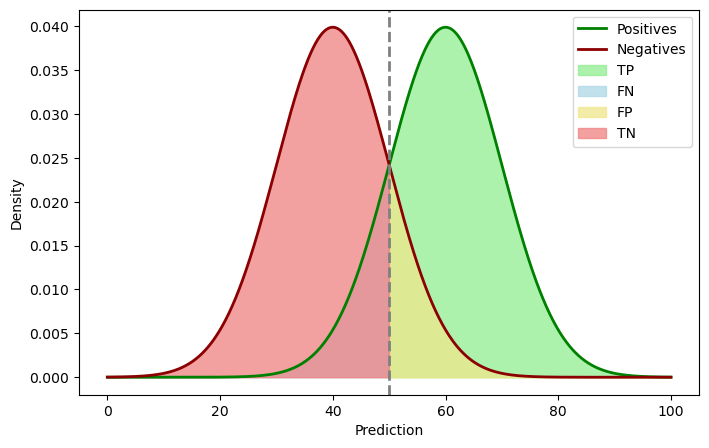

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate x values
x = np.linspace(0, 100, 1000)

# Define distributions
mu_pos, sigma_pos = 60, 10  # Mean and std for positives
mu_neg, sigma_neg = 40, 10  # Mean and std for negatives

# Compute densities
pos_density = norm.pdf(x, mu_pos, sigma_pos)
neg_density = norm.pdf(x, mu_neg, sigma_neg)

# Decision threshold
threshold = 50

# Create figure
plt.figure(figsize=(8, 5))

# Plot density curves
plt.plot(x, pos_density, color='green', lw=2, label='Positives')
plt.plot(x, neg_density, color='darkred', lw=2, label='Negatives')

# Fill TP, FN, FP, TN regions
plt.fill_between(x, 0, pos_density, where=(x >= threshold), color='lightgreen', alpha=0.75, label="TP")
plt.fill_between(x, 0, pos_density, where=(x < threshold), color='lightblue', alpha=0.75, label="FN")
plt.fill_between(x, 0, neg_density, where=(x >= threshold), color='khaki', alpha=0.75, label="FP")
plt.fill_between(x, 0, neg_density, where=(x < threshold), color='lightcoral', alpha=0.75, label="TN")

# Add threshold line
plt.axvline(threshold, color='gray', linestyle='dashed', linewidth=2)

# Labels and legend
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.legend()
plt.show()